### Import Library

In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

style.use("ggplot")

### Declare Global Variables

In [2]:
SIZE = 10 # Metrics Size

HM_EPISODES = 100000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 3000  # how often to play through env visually.

# start_q_table = "models/qtable-1658485591.pickle"
start_q_table = None # None or Filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dictionary
FOOD_N = 2  # food key in dictionary
ENEMY_N = 3  # enemy key in dictionary

# the dictionary of RGB value
d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}


### Define Object's Class

In [3]:
class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    
    def reset(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

## Game Environment

In [4]:
class GameEnv:
    def __init__(self):
        self.player = Blob()
        self.food = Blob()
        self.enemy = Blob()
        
    def observation(self):
        return (self.player-self.food, self.player-self.enemy)
    
    def step(self,action):
        self.reward = 0
        self.player.action(action)
        
        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############
        
        if self.player.x == self.enemy.x and self.player.y == self.enemy.y:
            self.reward = -ENEMY_PENALTY
        elif self.player.x == self.food.x and self.player.y == self.food.y:
            self.reward = FOOD_REWARD
        else:
            self.reward = -MOVE_PENALTY
        
        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.
        new_state = self.observation()
        
        if self.reward == FOOD_REWARD or self.reward == -ENEMY_PENALTY:
            done = True
        else:
            done = False
        return new_state, self.reward, done, ""
    
    def render(self):
        env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = d[FOOD_N]  # sets the food location tile to green color
        env[self.player.x][self.player.y] = d[PLAYER_N]  # sets the player tile to blue
        env[self.enemy.x][self.enemy.y] = d[ENEMY_N]  # sets the enemy location to red
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!

    def reset(self):
        self.player.reset()
        self.food.reset()
        self.enemy.reset()
        
    def close(self):
        cv2.destroyWindow("image")

## Construct Q Table

In [5]:
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

## Train from Environment

In [6]:
# can look up from Q-table with: print(q_table[((-9, -2), (3, 9))]) for example

episode_rewards = []

game_env = GameEnv()

for episode in range(HM_EPISODES):
    game_env.reset()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    done = False
    for i in range(200):
        obs = game_env.observation()
        #print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        new_obs, reward, done, _ = game_env.step(action)

        
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q
        
        episode_reward += reward
        
        if show:
            game_env.render()
            if done:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                cv2.waitKey(500)
            else:
                cv2.waitKey(1)

        if done:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

game_env.close()

on #0, epsilon is 0.9
3000 ep mean: nan


/home/tanjim/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanjim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #3000, epsilon is 0.49390083359356435
3000 ep mean: -170.876
on #6000, epsilon is 0.27104225936046566
3000 ep mean: -109.12133333333334
on #9000, epsilon is 0.14874221981913022
3000 ep mean: -81.92233333333333
on #12000, epsilon is 0.08162656262136181
3000 ep mean: -69.326
on #15000, epsilon is 0.044794919246742226
3000 ep mean: -56.865
on #18000, epsilon is 0.024582497729691496
3000 ep mean: -53.55
on #21000, epsilon is 0.01349035124500733
3000 ep mean: -38.967
on #24000, epsilon is 0.0074032174726434705
3000 ep mean: -37.117
on #27000, epsilon is 0.004062728090014504
3000 ep mean: -31.045333333333332
on #30000, epsilon is 0.0022295386559135037
3000 ep mean: -27.655333333333335
on #33000, epsilon is 0.0012235233340941692
3000 ep mean: -22.74


KeyboardInterrupt: 

## Plot reward graph & Store model(QTable)

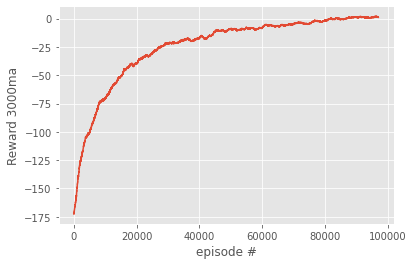

In [7]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')


plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Play with stored QTable(Model)

In [5]:
# Load Q Table
file_name = "qtable-1658641253.pickle"
with open(file_name, "rb") as f:
    q_table = pickle.load(f)


game_env = GameEnv()
game_loop = True
run_count = 0

while game_loop:
    run_count+=1
    game_env.reset()
    print(".................")

    episode_reward = 0
    for i in range(200):
        obs = game_env.observation()
        
        action = np.argmax(q_table[obs])

        #action = np.random.randint(0, 4)
        # Take the action!
        new_obs, reward, done, _ = game_env.step(action)
            
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q
        
        episode_reward += reward
        
        # DISPLAY
        game_env.render()
        
        if cv2.waitKey(30) == ord('q'):
            game_loop = False
            break
        
        if done:
            break
        
    print(f"Reward: {episode_reward}")
    
    if run_count==200:
        break
        
game_env.close()

.................
Reward: 9
.................
Reward: -63
.................
Reward: 13
.................
Reward: -8
.................
Reward: 3
.................
Reward: -71
.................
Reward: 11
.................
Reward: -26
.................
Reward: 10
.................
Reward: 13
.................
Reward: 21
.................
Reward: 6
.................
Reward: -68
.................
Reward: 17
.................
Reward: 9
.................
Reward: 11
.................
Reward: 23
.................
Reward: 1
.................
Reward: 19
.................
Reward: 19
.................
Reward: -22
.................
Reward: 18
.................
Reward: 19
.................
Reward: 11
.................
Reward: 23
.................
Reward: -200
.................
Reward: 5
.................
Reward: 17
.................
Reward: 16
.................
Reward: 17
.................
Reward: 17
.................
Reward: 15
.................
Reward: -304
.................
Reward: 16
...........

### Display QTable

In [17]:
file_name = "models/qtable-1658641253.pickle"
with open(file_name, "rb") as f:
    q_table = pickle.load(f)

print(q_table[((0,0),(0,0))])    
RANGE = 3
for x1 in range(RANGE):
    for y1 in range(RANGE):
        for x2 in range(RANGE):
            for y2 in range(RANGE):
                print(q_table[((x1,y1),(x2,y2))])

[-3.0126688703960443, -4.189355937645875, -2.6414336095875592, -2.675692648702852]
[-3.0126688703960443, -4.189355937645875, -2.6414336095875592, -2.675692648702852]
[-4.250471441412581, -4.0049823845166985, 12.057566818011573, -4.754519219322938]
[-4.200368615743132, -4.591515517467103, -2.42733559224443, 12.473811553424213]
[13.37227158218474, -2.0770608433014215, -3.0763805004859135, -2.48713255230753]
[-0.6671249113502808, -2.3386765945874015, -3.8520506673461803, 13.796955778020292]
[-0.7463457541802843, 15.790405374581276, -1.937986459531404, -2.7259428896603985]
[9.626190422965172, -2.9607840860427803, -3.2267409281413966, -0.5901870417494584]
[5.64879086430779, -4.44961605687093, -4.174655955490878, -4.994018275605799]
[6.363582194751942, -2.237282498816321, -2.846705131095068, -3.305742960463993]
[-4.735887866076595, -3.97025924576763, -4.508694051241826, 17.079045896542116]
[-11.474634060830628, -28.00806615406362, -11.486296750897985, -40.02163377251036]
[-3.389807301966071,

In [15]:
RANGE = 3
array = []
for x1 in range(RANGE):
    for y1 in range(RANGE):
        for x2 in range(RANGE):
            for y2 in range(RANGE):
                x = str(x1-x2)
                y = str(y1-y2)
                array.append(x+y)
                print(f"({x1},{y1})({x2},{y2}):  {x+y}")
#print(array)
                

(0,0)(0,0):  00
(0,0)(0,1):  0-1
(0,0)(0,2):  0-2
(0,0)(1,0):  -10
(0,0)(1,1):  -1-1
(0,0)(1,2):  -1-2
(0,0)(2,0):  -20
(0,0)(2,1):  -2-1
(0,0)(2,2):  -2-2
(0,1)(0,0):  01
(0,1)(0,1):  00
(0,1)(0,2):  0-1
(0,1)(1,0):  -11
(0,1)(1,1):  -10
(0,1)(1,2):  -1-1
(0,1)(2,0):  -21
(0,1)(2,1):  -20
(0,1)(2,2):  -2-1
(0,2)(0,0):  02
(0,2)(0,1):  01
(0,2)(0,2):  00
(0,2)(1,0):  -12
(0,2)(1,1):  -11
(0,2)(1,2):  -10
(0,2)(2,0):  -22
(0,2)(2,1):  -21
(0,2)(2,2):  -20
(1,0)(0,0):  10
(1,0)(0,1):  1-1
(1,0)(0,2):  1-2
(1,0)(1,0):  00
(1,0)(1,1):  0-1
(1,0)(1,2):  0-2
(1,0)(2,0):  -10
(1,0)(2,1):  -1-1
(1,0)(2,2):  -1-2
(1,1)(0,0):  11
(1,1)(0,1):  10
(1,1)(0,2):  1-1
(1,1)(1,0):  01
(1,1)(1,1):  00
(1,1)(1,2):  0-1
(1,1)(2,0):  -11
(1,1)(2,1):  -10
(1,1)(2,2):  -1-1
(1,2)(0,0):  12
(1,2)(0,1):  11
(1,2)(0,2):  10
(1,2)(1,0):  02
(1,2)(1,1):  01
(1,2)(1,2):  00
(1,2)(2,0):  -12
(1,2)(2,1):  -11
(1,2)(2,2):  -10
(2,0)(0,0):  20
(2,0)(0,1):  2-1
(2,0)(0,2):  2-2
(2,0)(1,0):  10
(2,0)(1,1):  1-1
(2,0)(1,

In [14]:
import collections
print([item for item, count in collections.Counter(array).items() if count > 1])

['00', '0-1', '0-2', '-10', '-1-1', '-1-2', '-20', '-2-1', '01', '-11', '-21', '02', '-12', '10', '1-1', '1-2', '11', '12', '20', '2-1', '21']
